<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [12]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import os
import pandas as pd
from skimage import io
from skimage.transform import resize

In [77]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, downloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos = df['photo_path'].apply(io.imread)\
                                .apply(lambda img: img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [78]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, downloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [79]:
#import numpy as np
#data = np.array(data, np.float32)
#Y = np.array(Y, np.float32)
assert len(data) == len(attrs)
print(f'Loaded {len(data)} images')

Loaded 13143 images


In [80]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(data, attrs, test_size=0.15, random_state=13)

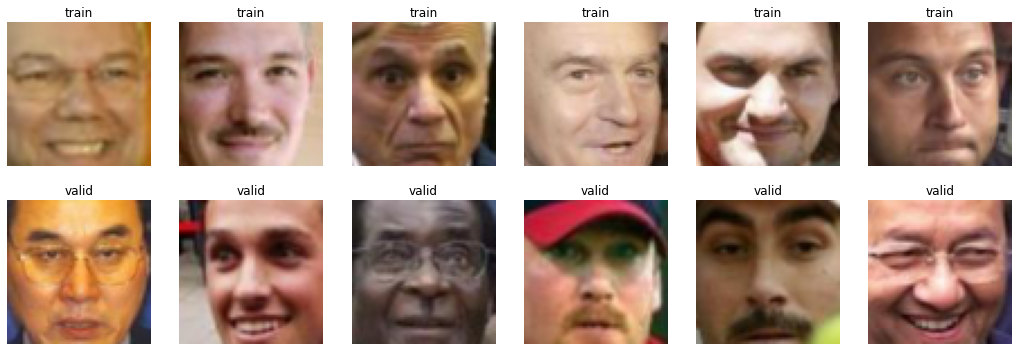

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.title('train')
    plt.imshow(X_tr[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.title('valid')
    plt.imshow(X_val[i])
plt.show();

In [81]:
import torch

In [82]:
#from torchvision import transforms

'''transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])'''

X_tr = torch.from_numpy(X_tr).float()

X_val = torch.from_numpy(X_val).float()


In [ ]:
X_tr.shape

torch.Size([11171, 64, 64, 3])

In [83]:
X_tr = torch.permute(X_tr, (0, 3, 1, 2))
X_val = torch.permute(X_val, (0, 3, 1, 2))

X_tr.shape


torch.Size([11171, 3, 64, 64])

In [ ]:
X_val.shape


torch.Size([1972, 3, 64, 64])

In [84]:
from torch.utils.data import DataLoader

batch_size = 10

tr_loader = DataLoader(X_tr, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(X_val, batch_size=batch_size, drop_last=True)

In [85]:
print(len(tr_loader), len(val_loader))


1117 197


## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [88]:
dim_code = 512 #<your code here> # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [89]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder>
        super().__init__()
        
        '''self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=64*64*3, out_features=512*4),
            nn.ReLU(),
            nn.Linear(in_features=512*4, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=dim_code)

        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512*4),
            nn.ReLU(),
            nn.Linear(in_features=512*4, out_features=64*64*3)
        )'''

        
        self.encoder = nn.Sequential( #64x64
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1), #32x32
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4, stride=2, padding=1), #16x16
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1), #8x8
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=dim_code, kernel_size=8, stride=1, padding=0) #1x1
            )
    
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=dim_code, out_channels=256, kernel_size=2, stride=2, padding=0), #2x2
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0), #4x4
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0), #8x8
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=0), #16x16
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0), #32x32
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2, padding=0), #64x64
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=1, stride=1, padding=0) #64x64
            )


    def forward(self, x):
        
        #<реализуйте forward проход автоэнкодера
        #в качестве возвращаемых переменных -- латентное представление картинки (latent_code) 
        #и полученная реконструкция изображения (reconstruction)>

        x = x.float()
        latent_code = self.encoder(x)
        reconstruction = torch.sigmoid(self.decoder(latent_code.view(-1, dim_code, 1, 1)))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        reconstruction = torch.permute(reconstruction, (0, 3, 1, 2))

        return reconstruction, latent_code

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [91]:
criterion = F.mse_loss #<loss>
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters()) #<Ваш любимый оптимизатор>

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Epoch № 6


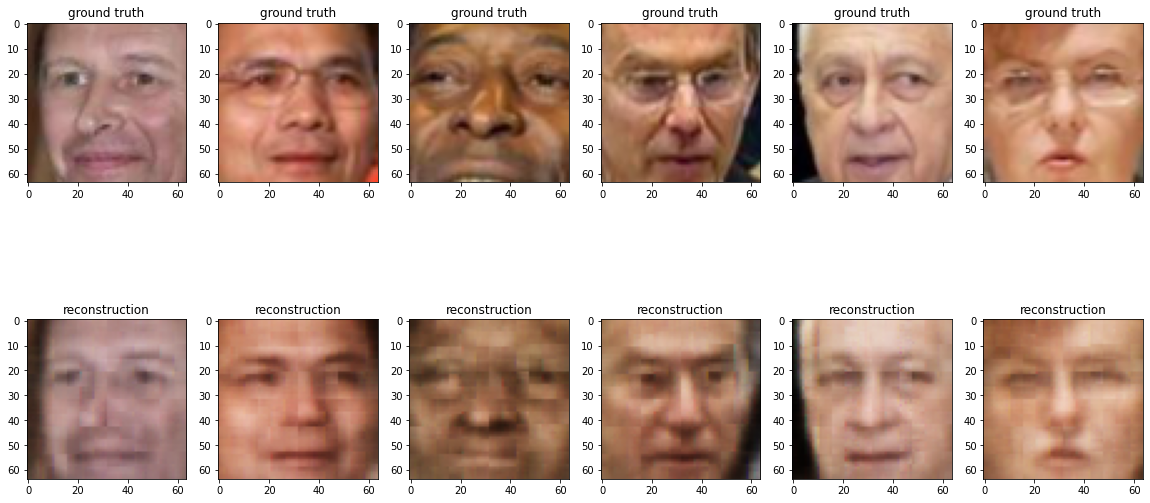

In [ ]:
from tqdm.notebook import tqdm
n_epochs = 7

train_losses_mean = []
train_losses = []
val_losses_mean = []
val_losses = []
latent_code_batch = []
latent_code_epoch = []

for epoch in tqdm(range(n_epochs)): #
    model.train()
    train_losses_per_epoch = []
    for X_batch in tr_loader:
        optimizer.zero_grad()
        reconstruction, latent_code = model.forward(X_batch.to(device))#
        loss = criterion(reconstruction, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

        latent_code_batch.append(latent_code.detach().cpu().numpy()) #список латентных векторов по батчам

    train_losses_mean.append(np.mean(train_losses_per_epoch)) #средние лоссы по эпохам
    train_losses += train_losses_per_epoch #лоссы по батчам
    latent_code_epoch.append(np.mean(latent_code_batch, axis=0)) #список латентных векторов по эпохам

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconstruction_val, latent_code_val = model.forward(batch.to(device)) #
          loss_val = criterion(reconstruction_val, batch.to(device))
          val_losses_per_epoch.append(loss_val.item())

    val_losses_mean.append(np.mean(val_losses_per_epoch))
    val_losses += val_losses_per_epoch

    # Visualize tools
    result = torch.permute(reconstruction_val, (0, 2, 3, 1))
    result = result.cpu().detach().numpy()
          
    batch = torch.permute(batch, (0, 2, 3, 1))
    ground_truth = batch.numpy()

    
    clear_output(wait=True)
    print('Epoch №', epoch)
    plt.figure(figsize=(20, 10)) #

    for k in range(6):

        plt.subplot(2, 6, k+1)
        plt.imshow((ground_truth[k] * 255).astype(np.uint8)) #(out * 255).astype(np.uint8)
        plt.title('ground truth')

        plt.subplot(2, 6, k+7)
        plt.imshow((result[k] * 255).astype(np.uint8))
        plt.title('reconstruction')
    
    plt.show()

In [ ]:
latent_code_all = (np.mean(latent_code_epoch, axis=0))
latent_code_all = (np.mean(latent_code_all, axis=0))
latent_code_all = torch.from_numpy(latent_code_all)
latent_code_all = latent_code_all.squeeze()

In [ ]:
latent_code_all.shape

torch.Size([512])

In [ ]:
def get_samples(latent_code_all, n=25):
  mu_tr = torch.mean(latent_code_all)
  disp_tr = torch.std(latent_code_all)
  sample_for_sampling = torch.empty(0, len(latent_code_all))
  for i in range(n):
    eps = torch.randn_like(latent_code_all)
    sample_i = mu_tr + (eps * disp_tr)
    sample_i = torch.unsqueeze(sample_i, dim=0)
    sample_for_sampling = torch.cat((sample_for_sampling, sample_i), 0)
  return sample_for_sampling

sample_for_sampling = get_samples(latent_code_all, n=25)
sample_for_sampling.shape

torch.Size([25, 512])

In [ ]:
#torch.save(model.state_dict(), 'model.pth')
#model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

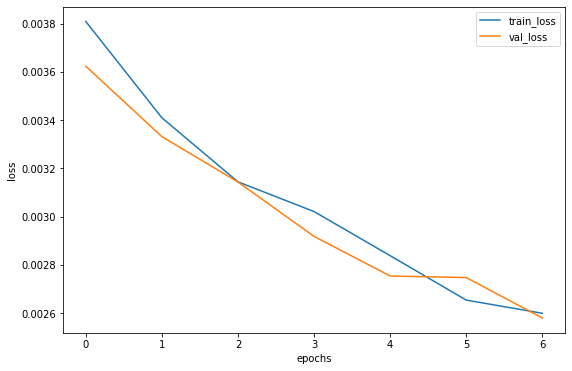

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(train_losses_mean, label="train_loss")
plt.plot(val_losses_mean, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

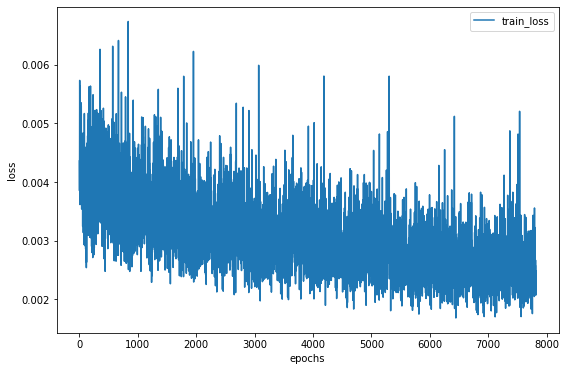

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(train_losses, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

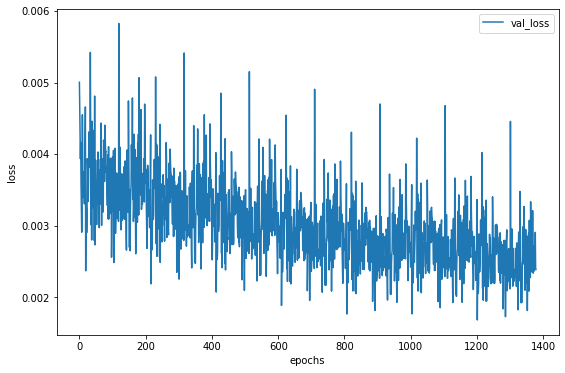

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
  model.eval()
  with torch.no_grad():
      for batch in val_loader:
        reconstruction, latent_code = model(batch.to(device))
        reconstruction = torch.permute(reconstruction, (0, 2, 3, 1))
        #reconstruction = reconstruction.view(-1, 64, 64, 3)
        result = reconstruction.cpu().detach().numpy()
        batch = torch.permute(batch, (0, 2, 3, 1))
        ground_truth = batch.numpy()
        break

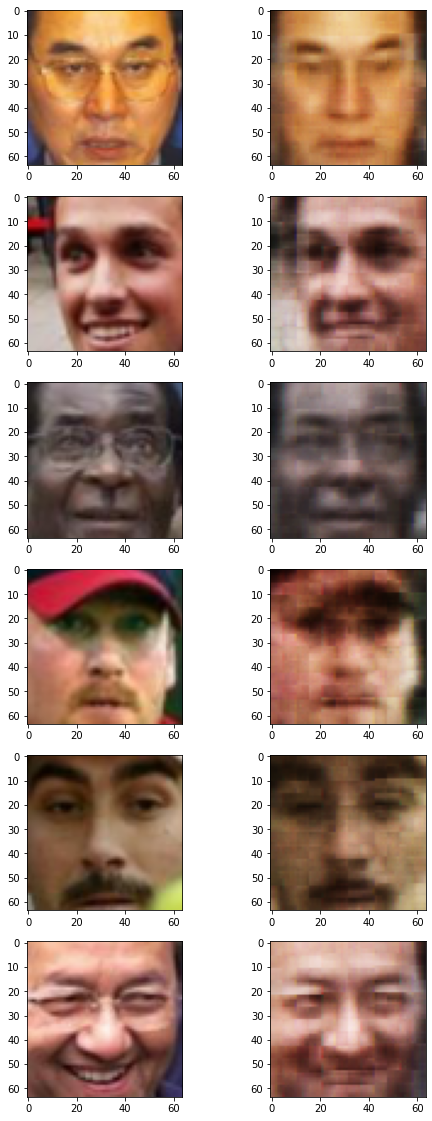

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:6], result[:6])):
  plt.subplot(6, 2, 2*i+1)
  plt.imshow((gt * 255).astype(np.uint8))
  plt.subplot(6, 2, 2*i+2)
  plt.imshow((res * 255).astype(np.uint8))

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
import random

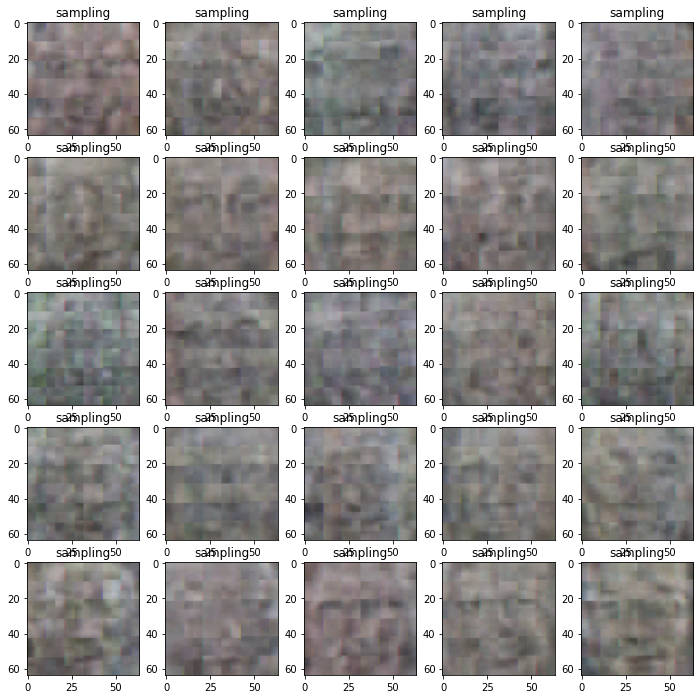

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
#z = np.random.randn(25, dim_code, 1, 1)
sample_for_sampling = sample_for_sampling.to(device)

z = torch.sigmoid(model.decoder(sample_for_sampling.view(-1, dim_code, 1, 1)))
z = z.view(-1, 64, 64, 3)
#z = torch.permute(z, (0, 3, 1, 2))
output = z.cpu().detach().numpy()

plt.figure(figsize=(12, 12)) #

for k in range(25):
  plt.subplot(5, 5, k+1)
  plt.imshow((output[k] * 255).astype(np.uint8)) #(out * 255).astype(np.uint8)
  plt.title('sampling')
plt.show()

#<выведите тут полученные картинки>

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs = attrs[attrs['Male'] < 0] #самые веселые все девушки, а самые грустные все парни. чтобы
#не примешивать к задаче смену пола, оставлю только девушек
attrs

Male     Asian  ... Wearing Necktie Wearing Necklace
78      -0.713895 -0.957024  ...       -0.268129        0.0648244
86      -0.265648  -2.17804  ...        0.116818        -0.418852
88      -0.975435 -0.746867  ...       -0.534467         0.670804
97       -1.04877  -1.42168  ...        0.559532        -0.398335
98      -0.595108  -0.89041  ...        0.519024      -0.00570664
...           ...       ...  ...             ...              ...
13112     -1.1796   1.29663  ...         -1.0243        -0.285297
13133   -0.507526  -1.37673  ...       -0.709985        0.0181152
13136 -0.00707805 -0.579276  ...        0.134016        -0.729354
13138   -0.205363 -0.202842  ...       -0.414024        -0.495178
13140  -0.0370013  -1.16415  ...       -0.399981         -1.07866

[2962 rows x 73 columns]

In [ ]:
smiles = attrs['Smiling'][attrs['Smiling'] > 2.6]
len(smiles)
#<ваш код здесь>

16

In [ ]:
smiles_id = smiles.index.tolist()
len(smiles_id)

16

In [ ]:
X_smiles = data[smiles_id]

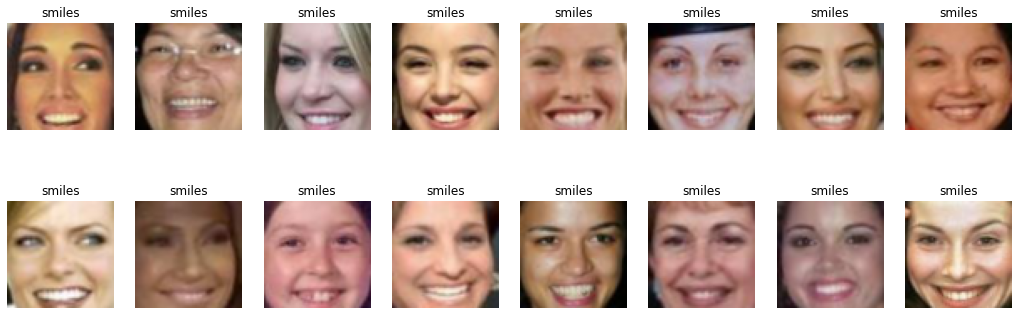

In [ ]:
plt.figure(figsize=(18, 6))
for i, id in enumerate(smiles_id):
    plt.subplot(2, 8, i+1)
    plt.axis("off")
    plt.title('smiles')
    plt.imshow(X_smiles[i])
plt.show();

In [ ]:
no_smiles = attrs['Smiling'][attrs['Smiling'] < -2.05]
no_smiles = no_smiles[:16]
no_smiles_id = no_smiles.index.tolist()
len(no_smiles_id)

16

In [ ]:
X_no_smiles = data[no_smiles_id]

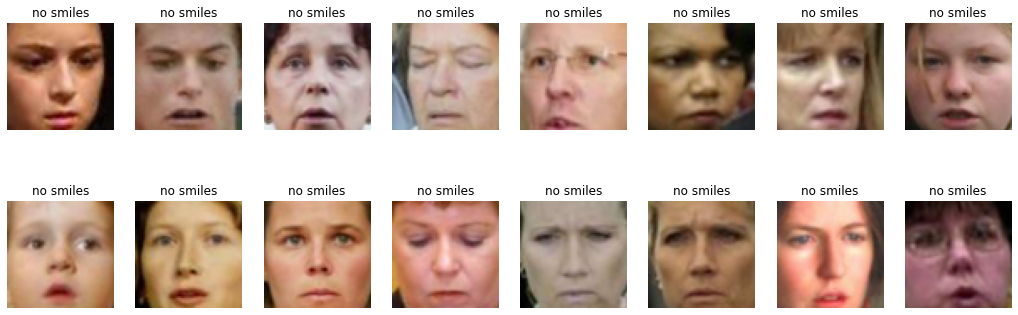

In [ ]:
plt.figure(figsize=(18, 6))
for i, id in enumerate(no_smiles_id):
    plt.subplot(2, 8, i+1)
    plt.axis("off")
    plt.title('no smiles')
    plt.imshow(X_no_smiles[i])
plt.show();

In [ ]:
X_smiles = torch.permute(torch.from_numpy(X_smiles), (0, 3, 1, 2))
X_no_smiles = torch.permute(torch.from_numpy(X_no_smiles), (0, 3, 1, 2))

In [ ]:
latent_smile = model.encoder(X_smiles.float().to(device))
latent_no_smile = model.encoder(X_no_smiles.float().to(device))
vector_smile = torch.mean((latent_smile - latent_no_smile), dim=0)

In [ ]:
for i in range(16):
  new_latent_no_smile[i] = latent_no_smile[i] + vector_smile

In [ ]:
output = torch.sigmoid(model.decoder(new_latent_no_smile))
output = output.view(-1, 64, 64, 3)
output = output.cpu().detach().numpy()

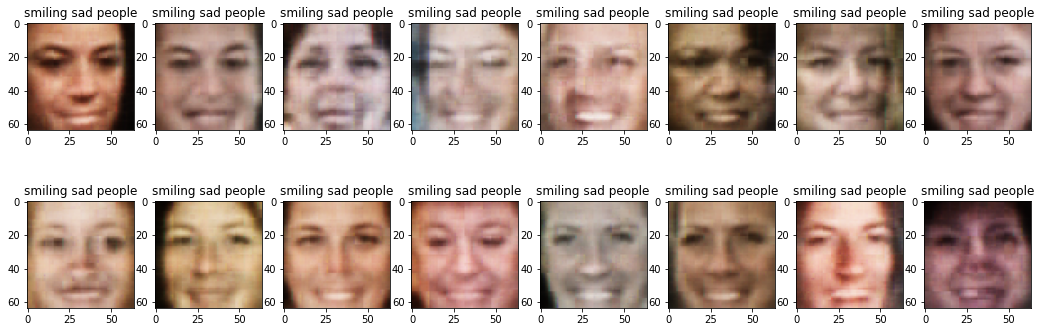

In [ ]:
plt.figure(figsize=(18, 6)) #
for k in range(16):
  plt.subplot(2, 8, k+1)
  plt.imshow((output[k] * 255).astype(np.uint8)) #(out * 255).astype(np.uint8)
  plt.title('smiling sad people')

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [14]:
from torchvision import transforms as tfs
import torch

In [15]:
batch_size = 32
# MNIST Dataset tr_loader = DataLoader(X_tr, batch_size=batch_size, drop_last=True)

data_tfs = tfs.Compose([
           tfs.ToTensor(),
           tfs.Normalize((0.5), (0.5))
           ])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=data_tfs, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=data_tfs, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
features = 64
class VAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=features*2)

        )
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=784)
        )

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] 
        logsigma = x[:, 1, :] 
        #z = self.gaussian_sampler(mu, logsigma)
        '''std = torch.exp(0.5 * logsigma) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        z = mu + (eps * std)'''
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        z = self.decoder(z)
        reconstruction = torch.sigmoid(z)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [16]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss 

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae
vae_model = VAE().to(device)
optimizer = optim.Adam(vae_model.parameters())

In [20]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

Epoch № 6


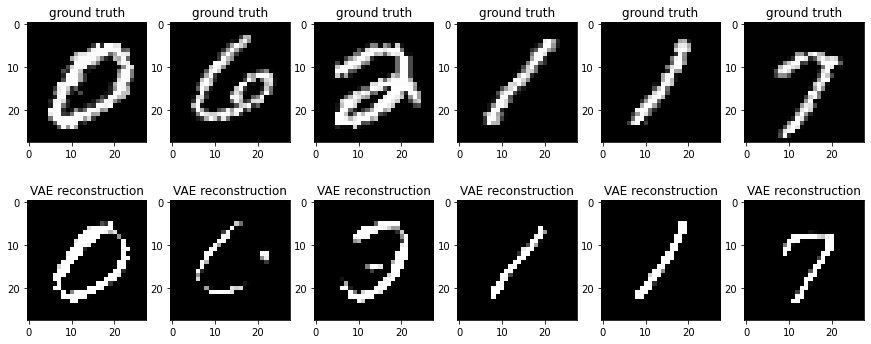

In [ ]:
#<обучите модель на датасете MNIST>
n_epochs = 7

train_losses_mean = []
train_losses = []
val_losses_mean = []
val_losses = []

for epoch in tqdm(range(n_epochs)): #_notebook
    vae_model.train()
    train_losses_per_epoch = []
    for X_batch, y_batch in train_loader:#next(iter(train_loader)):
        optimizer.zero_grad()
        mu, logsigma, reconstruction = vae_model.forward(X_batch.to(device))#.to(device) 
        loss = criterion(X_batch.to(device), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses_mean.append(np.mean(train_losses_per_epoch)) #средние лоссы по эпохам
    train_losses += train_losses_per_epoch #лоссы по батчам


    vae_model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X, y in test_loader:#next(iter(test_loader)):
          mu, logsigma, reconstruction_val = vae_model.forward(X.to(device)) #
          loss_val = criterion(X.to(device), mu, logsigma, reconstruction_val)
          val_losses_per_epoch.append(loss_val.item())

    val_losses_mean.append(np.mean(val_losses_per_epoch))
    val_losses += val_losses_per_epoch

    # Visualize tools
    #result = torch.permute(reconstruction_val)
    result = reconstruction_val.cpu().detach().numpy().squeeze()
          
    ground_truth = X.numpy().squeeze()

    
    clear_output(wait=True)
    print('Epoch №', epoch)
    plt.figure(figsize=(15, 6)) #

    for k in range(6):

        plt.subplot(2, 6, k+1)
        plt.imshow((ground_truth[k] * 255).astype(np.uint8), cmap='gray') #(out * 255).astype(np.uint8)
        plt.title('ground truth')

        plt.subplot(2, 6, k+7)
        plt.imshow((result[k] * 255).astype(np.uint8), cmap='gray')
        plt.title('VAE reconstruction')
    
    plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

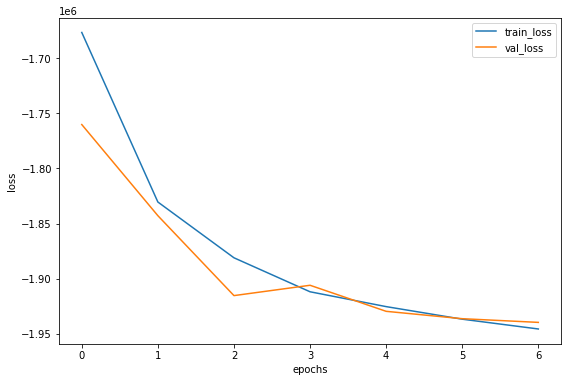

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(train_losses_mean, label="train_loss")
plt.plot(val_losses_mean, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
vae_model.eval()
with torch.no_grad():
  for X, y in test_loader:
    mu, logsigma, reconstruction_val = vae_model.forward(X.to(device)) #
    result = reconstruction_val.cpu().detach().numpy().squeeze()
    ground_truth = X.numpy().squeeze()
    break

#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

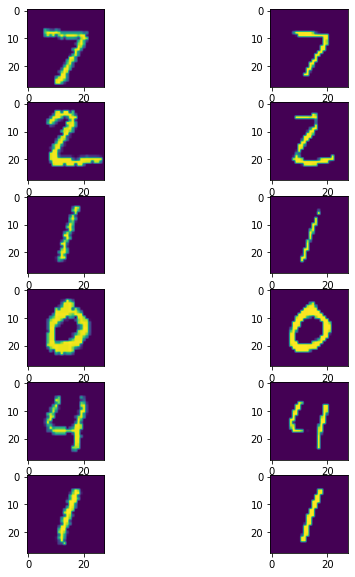

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))
for i, (gt, res) in enumerate(zip(ground_truth[:6], result[:6])):
  plt.subplot(6, 2, 2*i+1)
  plt.imshow((gt * 255).astype(np.uint8))
  plt.subplot(6, 2, 2*i+2)
  plt.imshow((res * 255).astype(np.uint8))

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

torch.Size([25, 1, 28, 28])


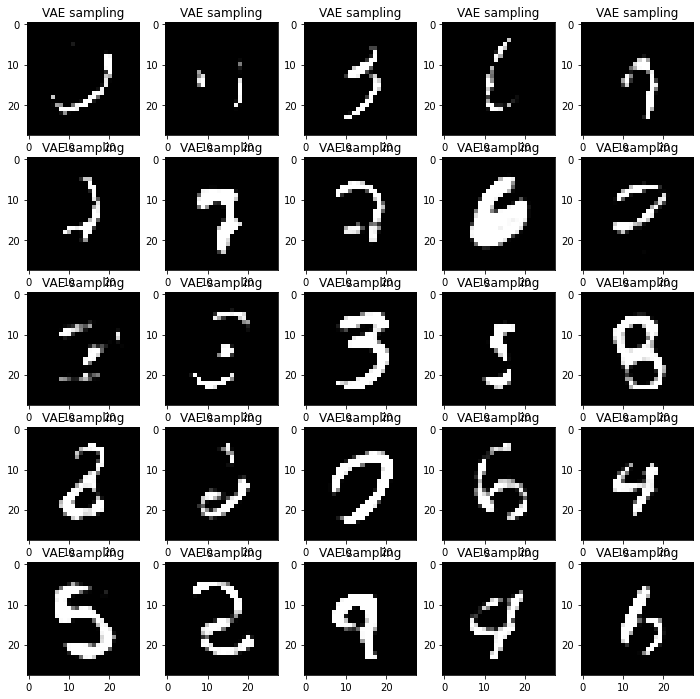

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(25)])
z = torch.from_numpy(z).float().to(device)
output = torch.sigmoid(vae_model.decode(z))
#output = output.view(-1, 64, 64, 3)
#output = torch.permute(output, (0, 2, 3, 1))
print(output.shape)
output = output.cpu().detach().numpy()
output = np.squeeze(output, axis = 1)


plt.figure(figsize=(12, 12)) #

for k in range(25):

  plt.subplot(5, 5, k+1)
  plt.imshow((output[k] * 255).astype(np.uint8), cmap='gray') #(out * 255).astype(np.uint8)
  plt.title('VAE sampling')
        
plt.show()

##<выведите тут полученные картинки>

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
test_loader_tsne = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)
X, y = next(iter(test_loader_tsne))

mu, logsigma = vae_model.encode(X.to(device))
sample = vae_model.gaussian_sampler(mu, logsigma)

from sklearn.manifold import TSNE
sample_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(sample.cpu().detach().numpy())
sample_embedded.shape
#<ваш код получения латентных представлений, применения TSNE и визуализации>

(10000, 2)

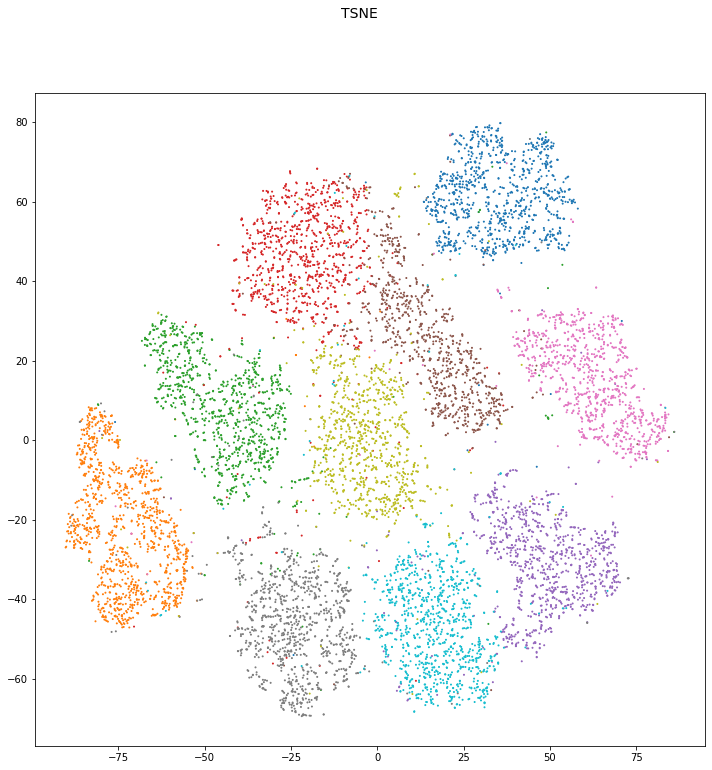

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle(
    "TSNE", fontsize=14
)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

ax = fig.add_subplot()
for i in range(10):
    ax.scatter(sample_embedded[:, 0], sample_embedded[:, 1], y==i, c=colors[i])

Что вы думаете о виде латентного представления?

Красивое

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [66]:
features = 64
class CVAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(CVAE, self).__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.e1 = nn.Sequential(
            nn.Linear(in_features=784+10, out_features=512),
            nn.ReLU()
        )
        self.e2 = nn.Sequential(
            nn.Linear(in_features=512+10, out_features=256),
            nn.ReLU()
        )
        self.e3 = nn.Sequential(
            nn.Linear(in_features=256+10, out_features=features*2)
        )
        # decoder 
        self.d1 = nn.Sequential(
            nn.Linear(in_features=features+10, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=784)
        )

    def encode(self, x, class_num):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.flatten(x).float()
        x = torch.concat((x, class_num), dim=1)
        x = self.e1(x)
        x = torch.concat((x, class_num), dim=1)
        x = self.e2(x)
        x = torch.concat((x, class_num), dim=1)
        x = self.e3(x).view(-1, 2, features)
        mu = x[:, 0, :] 
        logsigma = x[:, 1, :] 
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        z = torch.concat((z, class_num), dim=1)
        z = self.d1(z)
        
        reconstruction = torch.sigmoid(z)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x, class_num):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)

        return mu, logsigma, reconstruction

In [67]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae
cvae_model = CVAE().to(device)
optimizer = optim.Adam(cvae_model.parameters())

Epoch № 16


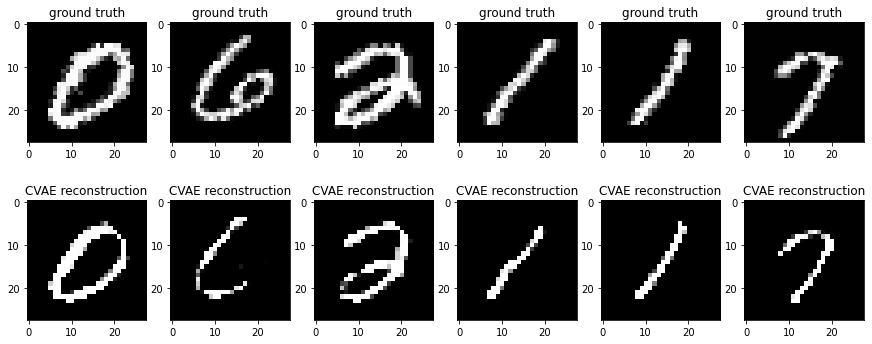

In [68]:
n_epochs = 17

train_losses_mean = []
train_losses = []
val_losses_mean = []
val_losses = []

for epoch in tqdm(range(n_epochs)): #_notebook
    cvae_model.train()
    train_losses_per_epoch = []
    for X_batch, y_batch in train_loader:#next(iter(train_loader)):
        optimizer.zero_grad()
        class_num = torch.nn.functional.one_hot(y_batch, num_classes=10) 
        mu, logsigma, reconstruction = cvae_model.forward(X_batch.to(device), class_num.to(device))#.to(device) 
        loss = criterion(X_batch.to(device), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses_mean.append(np.mean(train_losses_per_epoch)) #средние лоссы по эпохам
    train_losses += train_losses_per_epoch #лоссы по батчам


    cvae_model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X, y in test_loader:#next(iter(test_loader)):
          class_num = torch.nn.functional.one_hot(y, num_classes=10)
          mu, logsigma, reconstruction_val = cvae_model.forward(X.to(device), class_num.to(device)) #
          loss_val = criterion(X.to(device), mu, logsigma, reconstruction_val)
          val_losses_per_epoch.append(loss_val.item())

    val_losses_mean.append(np.mean(val_losses_per_epoch))
    val_losses += val_losses_per_epoch

    # Visualize tools
    #result = torch.permute(reconstruction_val)
    result = reconstruction_val.cpu().detach().numpy().squeeze()
          
    ground_truth = X.numpy().squeeze()

    
    clear_output(wait=True)
    print('Epoch №', epoch)
    plt.figure(figsize=(15, 6)) #

    for k in range(6):

        plt.subplot(2, 6, k+1)
        plt.imshow((ground_truth[k] * 255).astype(np.uint8), cmap='gray') #(out * 255).astype(np.uint8)
        plt.title('ground truth')

        plt.subplot(2, 6, k+7)
        plt.imshow((result[k] * 255).astype(np.uint8), cmap='gray')
        plt.title('CVAE reconstruction')
    
    plt.show()

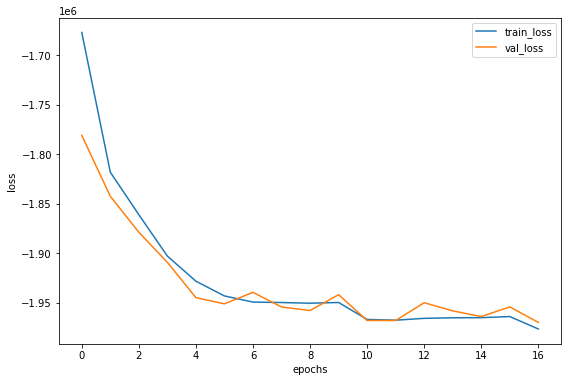

In [69]:
plt.figure(figsize=(9, 6))
plt.plot(train_losses_mean, label="train_loss")
plt.plot(val_losses_mean, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

(10, 64)


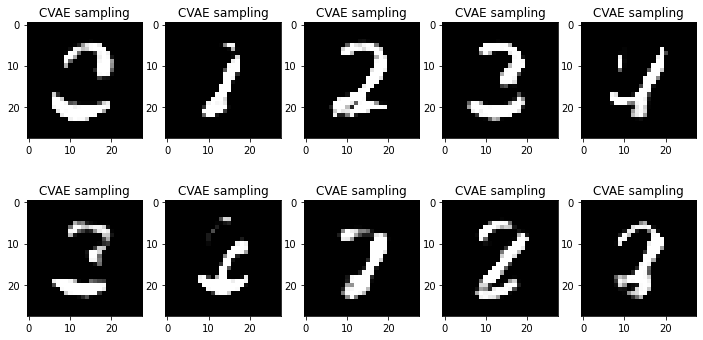

In [76]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array(np.random.normal(0, 1, features))#for i in range(10)]
z0 = z[:]
for i in range(9):
  z=np.vstack((z0, z)) 
print(z.shape)

nums = torch.eye(10).to(device)
z = torch.from_numpy(z).float().to(device)

plt.figure(figsize=(12, 6)) #

'''for k in range(10):
  output = torch.sigmoid(cvae_model.decode(z.unsqueeze(dim=0), nums[k].unsqueeze(dim=0)))
  output = output.permute(0, 2, 3, 1)
  output = output.cpu().detach().numpy()
  output = np.squeeze(output)

  plt.subplot(2, 5, k+1)
  plt.imshow((output * 255).astype(np.uint8), cmap='gray') #(out * 255).astype(np.uint8)
  plt.title('CVAE sampling')
        
plt.show()'''

output = torch.sigmoid(cvae_model.decode(z, nums))
output = output.permute(0, 2, 3, 1)
output = output.cpu().detach().numpy()
output = np.squeeze(output)

for k in range(10):
  plt.subplot(2, 5, k+1)
  plt.imshow((output[k] * 255).astype(np.uint8), cmap='gray') #(out * 255).astype(np.uint8)
  plt.title('CVAE sampling')
        
plt.show()
##<выведите тут полученные картинки> должны получиться цифры от 0 до 9 по порядку

Splendid! Вы великолепны!

ну токое, 3 и 9 совсем не удались


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [71]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
test_loader_tsne = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)
X, y = next(iter(test_loader_tsne))
class_num = torch.nn.functional.one_hot(y, num_classes=10)

mu, logsigma = cvae_model.encode(X.to(device), class_num.to(device))
sample = cvae_model.gaussian_sampler(mu, logsigma)

from sklearn.manifold import TSNE
sample_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(sample.cpu().detach().numpy())
sample_embedded.shape


(10000, 2)

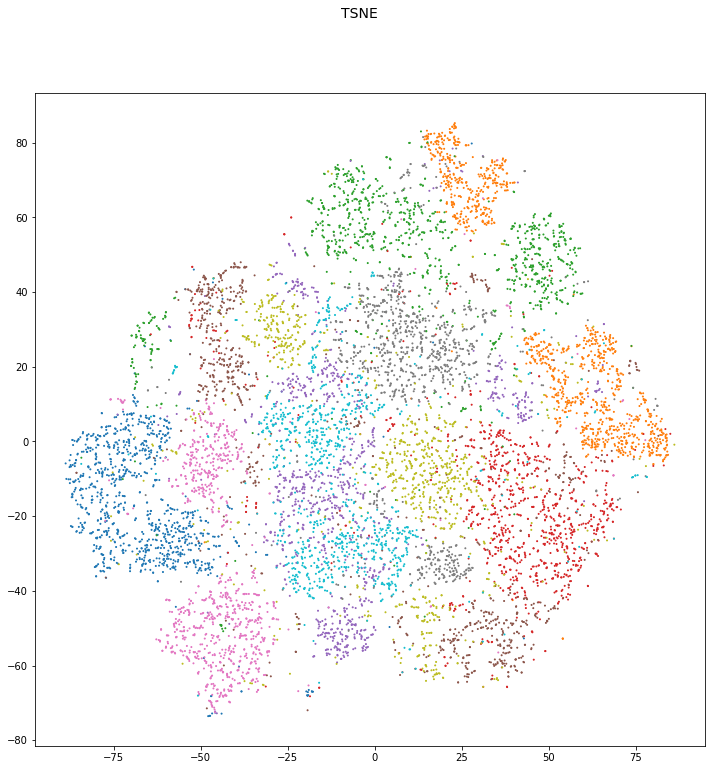

In [72]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle(
    "TSNE", fontsize=14
)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

ax = fig.add_subplot()
for i in range(10):
    ax.scatter(sample_embedded[:, 0], sample_embedded[:, 1], y==i, c=colors[i])

# МЯУ!!!

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

У VAE классы разделены лучше, точки сгруппированы в кластеры. У CVAE классы плавно перетекают друг в друга, можно отследить точки, похожие на 2 или более классов одновременно.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [86]:
noise_factor = 0.5
X_tr_noisy = X_tr + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_tr.shape) 
X_val_noisy = X_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val.shape) 

In [93]:
from torch.utils.data import DataLoader

batch_size = 10

tr_loader = DataLoader(X_tr_noisy.float(), batch_size=batch_size, drop_last=True)
val_loader = DataLoader(X_val_noisy.float(), batch_size=batch_size, drop_last=True)

Epoch № 6


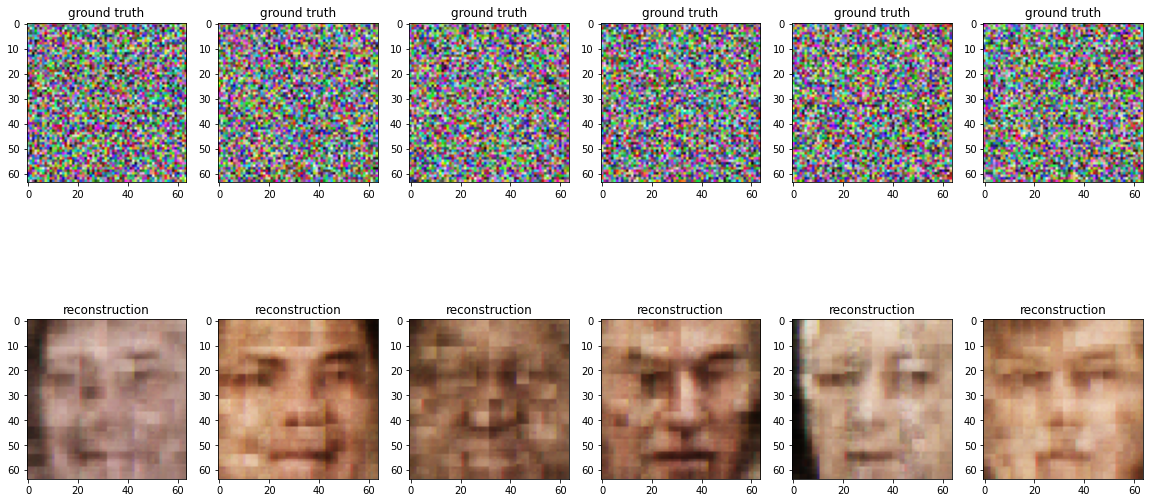

In [94]:
#<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

from tqdm.notebook import tqdm
n_epochs = 7

train_losses_mean = []
train_losses = []
val_losses_mean = []
val_losses = []
latent_code_batch = []
latent_code_epoch = []

for epoch in tqdm(range(n_epochs)): #
    model.train()
    train_losses_per_epoch = []
    for X_batch in tr_loader:
        optimizer.zero_grad()
        reconstruction, latent_code = model.forward(X_batch.to(device))#
        loss = criterion(reconstruction, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

        latent_code_batch.append(latent_code.detach().cpu().numpy()) #список латентных векторов по батчам

    train_losses_mean.append(np.mean(train_losses_per_epoch)) #средние лоссы по эпохам
    train_losses += train_losses_per_epoch #лоссы по батчам
    latent_code_epoch.append(np.mean(latent_code_batch, axis=0)) #список латентных векторов по эпохам

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconstruction_val, latent_code_val = model.forward(batch.to(device)) #
          loss_val = criterion(reconstruction_val, batch.to(device))
          val_losses_per_epoch.append(loss_val.item())

    val_losses_mean.append(np.mean(val_losses_per_epoch))
    val_losses += val_losses_per_epoch

    # Visualize tools
    result = torch.permute(reconstruction_val, (0, 2, 3, 1))
    result = result.cpu().detach().numpy()
          
    batch = torch.permute(batch, (0, 2, 3, 1))
    ground_truth = batch.numpy()

    
    clear_output(wait=True)
    print('Epoch №', epoch)
    plt.figure(figsize=(20, 10)) #

    for k in range(6):

        plt.subplot(2, 6, k+1)
        plt.imshow((ground_truth[k] * 255).astype(np.uint8)) #(out * 255).astype(np.uint8)
        plt.title('ground truth')

        plt.subplot(2, 6, k+7)
        plt.imshow((result[k] * 255).astype(np.uint8))
        plt.title('reconstruction')
    
    plt.show()

In [ ]:
#<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

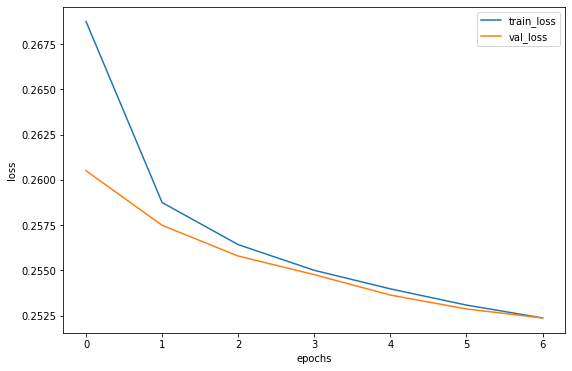

In [95]:
plt.figure(figsize=(9, 6))
plt.plot(train_losses_mean, label="train_loss")
plt.plot(val_losses_mean, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

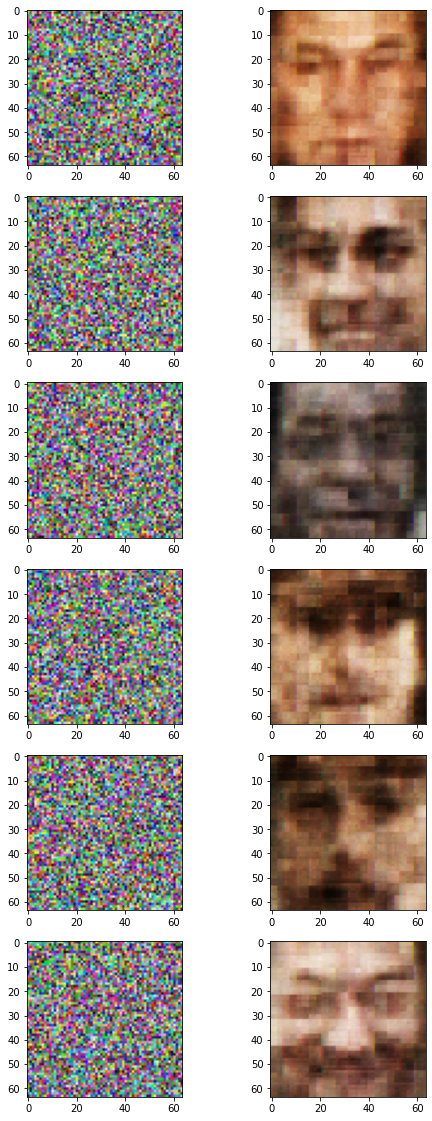

In [97]:
model.eval()
with torch.no_grad():
  for batch in val_loader:
    reconstruction, latent_code = model(batch.to(device))
    reconstruction = torch.permute(reconstruction, (0, 2, 3, 1))
    result = reconstruction.cpu().detach().numpy()
    batch = torch.permute(batch, (0, 2, 3, 1))
    ground_truth = batch.numpy()
    break

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:6], result[:6])):
  plt.subplot(6, 2, 2*i+1)
  plt.imshow((gt * 255).astype(np.uint8))
  plt.subplot(6, 2, 2*i+2)
  plt.imshow((res * 255).astype(np.uint8))

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

In [ ]:
import numpy as np

TARGETS = np.linspace(4, 100, 25)

def loss(prediction: float) -> float:
    return np.abs(TARGETS - prediction).sum() # find x = argmin_p loss(p)